## Visualizing Original Geoparser - By Years

We have used the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) with the original language model for finding the Name Entities for the NLS collections, and select just the ones regarding with places. Later, once we have the locations entities, we have used the georesolver to resolve these locations.
                       
The query for running that we have used is the following: 

`spark-submit --driver-memory 12g --py-files defoe.zip defoe/run_query.py sparql_data_chapbooks.txt sparql defoe
.sparql.queries.geoparser_by_year config_file_chapbooks_geo.yml   -r results_test/results_chapbooks_geo_kg_word
s.yml  -n 15`



### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

/var/folders/4w/57rlv27n3g9b001td63pv1j00000gq/T/ipykernel_60376/2040254443.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Functions

In [2]:
def read_query_results(filename):
    with open('../results/'+filename, 'r') as f:
        query_results = yaml.load(f,Loader=yaml.Loader)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution"]
            archive = k["archive_filename"]
            title = k["title"]
            page = k["page number"]
            serie = k["serie"]
            uri = k["uri"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type({}) :
                        c_locs=[]
                        c_locs.append(locs[t]["lat"])
                        c_locs.append(locs[t]["long"])
                        c_locs.append(t.split("-")[0])
                        c_locs.append(locs[t]["snippet"])
                        c_locs.append(page)
                        c_locs.append(year)
                        c_locs.append(archive)
                        c_locs.append(title)
                        c_locs.append(uri)
                        data.append(c_locs)
                            

                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Snippet', 'Page', 'Year', 'Archive_id', 'Title', 'URI'])
                    dfs.append(df_page)
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.8, top=0.95)
    fig.set_size_inches(25, 45)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned and resolved using the Original Geoparser ')
        
    elif plot_type == "total": 
        fig.suptitle('15 Places most mentioned (resolved and not) using the Original Geoparser ')
    else:
        fig.suptitle('15 Places most mentioned but not resolved using the Original Geoparser')
    
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='orange')
            axs[i,0].set_title('Year %s' %y)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='coral')
            axs[i,0].set_title('Year %s' %y)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=25)
        fig.canvas.draw()
        axs[i,0].set_yticklabels(axs[i,0].get_yticklabels())  
        axs[i,0].set_ylabel('Frequency') 
        i=i +1 

In [7]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(years_list):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(years_list):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50)
    plt.title('Yearly cumulative frequencies using \n'+ 'the Original Geoparser')
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places') 
    plt.xlabel("Years") 
    plt.show()
       

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages/terms from a KG
- Identifies *entities*.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata




As a result we get a file per book with an entry per page with the following information:

    * archive_filename: Archive (Book| Edition) id 
    * georesolution: Page's geolocations after applying the georesolver
    * page_number: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * year: Publication year 
    * uri: Page uri
    

`Example:
     
   '1800':
- archive_filename: 104184353-mets.xml
  georesolution:
    Edinburgh-rb4:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: his motlier , and into Edinburgh he goes , to a
      type: ''
  numWords: '372'
  page number: '6'
  part: None
  serie: '240'
  title: history and comical transactions of Lothian Tom, in six parts,1800
  uri: https://w3id.org/nls/i/Page/9937094823804340_104184353_6
  volume: '1'
  volumeId: '104184353'
  volumeTitle: history and comical transactions of Lothian Tom, in six parts
- archive_filename: 104184487-mets.xml
  georesolution:
    Bawn-rb9:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: ftcaling my lair Cobleejt 1 Bawn . Then in the cold
      type: ''
    Reilly-rb6:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: '! 3 taken was poor Reilly with his fair Cooleen Bawn'
      type: ''
    Reilly-rb7:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: . nd taken was poor Reilly and laid in Sligo gbal
      type: ''
    Sligo-rb8:
      in-cc: ''
      lat: ''
      long: ''
      pop: ''
      snippet: poor Reilly and laid in Sligo gbal , . 11 this
      type: ''
  numWords: '287'
  page number: '5'
  part: None
  serie: '370'
  title: Four excellent new songs,1800
  uri: https://w3id.org/nls/i/Page/9937146693804340_104184487_5
  volume: '1'
  volumeId: '104184487'
  volumeTitle: Four excellent new songs`


### Reading the file and creating the first dataframe

In [8]:
results=read_query_results('results_chapbooks_geo_kg_words.yml')

In [9]:
df_total= geresolution_dataframe(results)

In [10]:
df_total.head(15)

Latitude Longitude      Place  \
0                     Edinburgh   
0                          Bawn   
1                        Reilly   
2                        Reilly   
3                         Sligo   
0                         CHISM   
0                          Inna   
1                          Weil   
2                        Willie   
3                        Willie   
4                        Willie   
5                        Willie   
6                        Willie   
7                        Willie   
8                        Willie   

                                             Snippet Page  Year  \
0    his motlier , and into Edinburgh he goes , to a    6  1800   
0  ftcaling my lair Cobleejt 1 Bawn . Then in the...    5  1800   
1  ! 3 taken was poor Reilly with his fair Coolee...    5  1800   
2  . nd taken was poor Reilly and laid in Sligo gbal    5  1800   
3     poor Reilly and laid in Sligo gbal , . 11 this    5  1800   
0              X , ] THE CATE CHISM . That is to say   13  1800   
0          wife , for ye w Inna ken their Drape wi ’    3  1800   
1            a w ise Willie . Weil , mither , l will    3  1800   
2         e you the better ! Willie . Bat mither , i    3  1800   
3         t ! Muher Indeed , Willie , ye may try gin    3  1800   
4            but tak my advice , Willie an ’ ne ’ er    3  1800   
5  as a browfterwile ’s backlide Willie Well , mi...    3  1800   
6      ? Mither . Indeed , Willie , ye may try Belly    3  1800   
7          to court a w ise Willie . Weil , mither ,    3  1800   
8   , for my bleffi ig Willie , lae the kifies thick    3  1800   

           Archive_id                                              Title  \
0  104184353-mets.xml  history and comical transactions of Lothian To...   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   
2  104184487-mets.xml                      Four excellent new songs,1800   
3  104184487-mets.xml                      Four excellent new songs,1800   
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186547-mets.xml                              art of courtship,1800   
1  104186547-mets.xml                              art of courtship,1800   
2  104186547-mets.xml                              art of courtship,1800   
3  104186547-mets.xml                              art of courtship,1800   
4  104186547-mets.xml                              art of courtship,1800   
5  104186547-mets.xml                              art of courtship,1800   
6  104186547-mets.xml                              art of courtship,1800   
7  104186547-mets.xml                              art of courtship,1800   
8  104186547-mets.xml                              art of courtship,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9937094823804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...  
2  https://w3id.org/nls/i/Page/9937146693804340_1...  
3  https://w3id.org/nls/i/Page/9937146693804340_1...  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740643804340_1...  
1  https://w3id.org/nls/i/Page/9937740643804340_1...  
2  https://w3id.org/nls/i/Page/9937740643804340_1...  
3  https://w3id.org/nls/i/Page/9937740643804340_1...  
4  https://w3id.org/nls/i/Page/9937740643804340_1...  
5  https://w3id.org/nls/i/Page/9937740643804340_1...  
6  https://w3id.org/nls/i/Page/9937740643804340_1...  
7  https://w3id.org/nls/i/Page/9937740643804340_1...  
8  https://w3id.org/nls/i/Page/9937740643804340_1...

### 1. Generic Explorations 

**Important: Number of Places that has been identified!**

In [11]:
df_total[["Place"]].count()

Place    12762
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [12]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [13]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [14]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

In [15]:
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

In [16]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude      11581
Longitude     11581
Place         11581
Snippet       11581
Page          11581
Year          11581
Archive_id    11581
Title         11581
URI           11581
dtype: int64

**Important: Counting the total number of places identified - included the not resolved ones**

In [17]:
df_total.groupby("Year").count()

Latitude  Longitude  Place  Snippet  Page  Archive_id  Title  URI
Year                                                                   
1800       963        963    963      963   963         963    963  963
1801       302        302    302      302   302         302    302  302
1802       180        180    180      180   180         180    180  180
1803        86         86     86       86    86          86     86   86
1804        72         72     72       72    72          72     72   72
...        ...        ...    ...      ...   ...         ...    ...  ...
1870        43         43     43       43    43          43     43   43
1871        20         20     20       20    20          20     20   20
1873         1          1      1        1     1           1      1    1
1879         4          4      4        4     4           4      4    4
1880        65         65     65       65    65          65     65   65

[64 rows x 8 columns]

**Important: Number of Places that has been identified AND  resolved!**

In [18]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude      1181
Longitude     1181
Place         1181
Snippet       1181
Page          1181
Year          1181
Archive_id    1181
Title         1181
URI           1181
dtype: int64

### 2. Explorations with georesolved places

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [19]:
df_resolved = df_total[df_total['Latitude'] != '']

In [20]:
df_resolved.count()

Latitude      1181
Longitude     1181
Place         1181
Snippet       1181
Page          1181
Year          1181
Archive_id    1181
Title         1181
URI           1181
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [21]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [22]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_capitalized.head(15)

Latitude Longitude     Place  \
0   49.3522   43.9894      Tary   
0  49.43333   4.16667     Sault   
1        56        -4  Scotland   
0  47.91667  -3.78333   Barbary   
0  24.12638  89.86078      Arra   
1  24.12638  89.86078      Arra   
2  52.50456  39.52127      Pady   
3  52.50456  39.52127      Pady   
4  52.50456  39.52127      Pady   
5  52.50456  39.52127      Pady   
6  52.50456  39.52127      Pady   
0  35.63945   37.3736     Allas   
1   6.23438   7.46085       Ihe   
0  52.16045  -0.70312   England   
1        53        -8   Ireland   

                                             Snippet Page  Year  \
0               of Manners , avoid unnectf Tary         2  1800   
0           a wife r for one Sault , got a wife with    3  1800   
1  was the ulelulleft fair in Scotland jj kept ? ...    3  1800   
0  ress , A lady of Barbary and her huibaiid htin...   11  1800   
0              art thou ? Pady . Arra , dear ( hoy ,   19  1800   
1  foldie last , Teag . Arra , desrhoney I was three   19  1800   
2  of whvtprofcffibn art thou ? Pady . Arra , dear (   19  1800   
3         me . Tom . What Pady , was your religion '   19  1800   
4            . Tom . O then Pady how did you end the   19  1800   
5            . How old was you Pady , when you was a   19  1800   
6           . Tom . O but Pady , by your account you   19  1800   
0           It » 4ekt , dear Allas , 1 never can pay    4  1800   
1     a hall in the highlands Ihe never thoug M on :    4  1800   
0  breed Our Captain ciy 'd England and Ireland i...    4  1800   
1  Captain ciy 'd England and Ireland iny boys , v !    4  1800   

           Archive_id                                              Title  \
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186550-mets.xml  Scots piper's queries: or, John Falkirk's cari...   
1  104186550-mets.xml  Scots piper's queries: or, John Falkirk's cari...   
0  104186496-mets.xml  history of the seven wise mistresses of Rome,1800   
0  104184355-mets.xml             comical sayings of Pady from Cork,1800   
1  104184355-mets.xml             comical sayings of Pady from Cork,1800   
2  104184355-mets.xml             comical sayings of Pady from Cork,1800   
3  104184355-mets.xml             comical sayings of Pady from Cork,1800   
4  104184355-mets.xml             comical sayings of Pady from Cork,1800   
5  104184355-mets.xml             comical sayings of Pady from Cork,1800   
6  104184355-mets.xml             comical sayings of Pady from Cork,1800   
0  104184489-mets.xml                     Three excellent new songs,1800   
1  104184489-mets.xml                     Three excellent new songs,1800   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740933804340_1...  
1  https://w3id.org/nls/i/Page/9937740933804340_1...  
0  https://w3id.org/nls/i/Page/9937636163804340_1...  
0  https://w3id.org/nls/i/Page/9937095373804340_1...  
1  https://w3id.org/nls/i/Page/9937095373804340_1...  
2  https://w3id.org/nls/i/Page/9937095373804340_1...  
3  https://w3id.org/nls/i/Page/9937095373804340_1...  
4  https://w3id.org/nls/i/Page/9937095373804340_1...  
5  https://w3id.org/nls/i/Page/9937095373804340_1...  
6  https://w3id.org/nls/i/Page/9937095373804340_1...  
0  https://w3id.org/nls/i/Page/9937146803804340_1...  
1  https://w3id.org/nls/i/Page/9937146803804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...

In [23]:
df_capitalized.groupby("Year").count()

Latitude  Longitude  Place  Snippet  Page  Archive_id  Title  URI
Year                                                                   
1800        71         71     71       71    71          71     71   71
1801        31         31     31       31    31          31     31   31
1802        17         17     17       17    17          17     17   17
1803         3          3      3        3     3           3      3    3
1804         4          4      4        4     4           4      4    4
1805         6          6      6        6     6           6      6    6
1806        16         16     16       16    16          16     16   16
1807         8          8      8        8     8           8      8    8
1808         1          1      1        1     1           1      1    1
1809         4          4      4        4     4           4      4    4
1810        31         31     31       31    31          31     31   31
1811         1          1      1        1     1           1      1    1
1812        21         21     21       21    21          21     21   21
1813        42         42     42       42    42          42     42   42
1814         7          7      7        7     7           7      7    7
1815        50         50     50       50    50          50     50   50
1816         5          5      5        5     5           5      5    5
1817        16         16     16       16    16          16     16   16
1818         1          1      1        1     1           1      1    1
1819         2          2      2        2     2           2      2    2
1820        76         76     76       76    76          76     76   76
1821        16         16     16       16    16          16     16   16
1822        22         22     22       22    22          22     22   22
1823        24         24     24       24    24          24     24   24
1824         2          2      2        2     2           2      2    2
1825        23         23     23       23    23          23     23   23
1826         4          4      4        4     4           4      4    4
1827        30         30     30       30    30          30     30   30
1828        59         59     59       59    59          59     59   59
1829         6          6      6        6     6           6      6    6
1830        16         16     16       16    16          16     16   16
1832        17         17     17       17    17          17     17   17
1833         5          5      5        5     5           5      5    5
1838         6          6      6        6     6           6      6    6
1839        83         83     83       83    83          83     83   83
1840       285        285    285      285   285         285    285  285
1841         3          3      3        3     3           3      3    3
1842        17         17     17       17    17          17     17   17
1844         3          3      3        3     3           3      3    3
1850        76         76     76       76    76          76     76   76
1851        27         27     27       27    27          27     27   27
1852        36         36     36       36    36          36     36   36
1855         2          2      2        2     2           2      2    2
1864         1          1      1        1     1           1      1    1
1880         5          5      5        5     5           5      5    5

### Visualizing the 15 places more mentioned (and resolved) per year

In [34]:
mpl.rcParams['figure.dpi']=300
years_list_total = df_capitalized['Year'].unique()

## JUST A TRICK TO VISUALIZE THE FIRST 10 YEARS
#years_list=years_list_total[0:10]
years_list=years_list_total[:]
print(years_list)
###

filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'United presbyterian']    
    df_max_filter= df_max_geolocations[~df_max_geolocations['Place'].isin(filter_list)]
    place_label= df_max_filter['Place'].tolist()[0:15]
    place_freq= df_max_filter['count'].tolist()[0:15]
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

['1800' '1801' '1802' '1803' '1804' '1805' '1806' '1807' '1808' '1809'
 '1810' '1811' '1812' '1813' '1814' '1815' '1816' '1817' '1818' '1819'
 '1820' '1821' '1822' '1823' '1824' '1825' '1826' '1827' '1828' '1829'
 '1830' '1832' '1833' '1838' '1839' '1840' '1841' '1842' '1844' '1850'
 '1851' '1852' '1855' '1864' '1880']


In [35]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

/var/folders/4w/57rlv27n3g9b001td63pv1j00000gq/T/ipykernel_60376/4115186138.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,0].set_yticklabels(axs[i,0].get_yticklabels())


In [36]:
#As an example, we can get the number of places by years - e.g. 1828.
df_group_places_years["1828"]

Place  count
13   Scotland      5
12      Perth      3
1    Culloden      2
2       Egypt      2
3     England      2
4       Frith      2
5       India      2
14   St cloud      2
0       Albyn      1
6    Lochaber      1
7      London      1
8   Macdonald      1
9       Macon      1
10      Mahec      1
11      Murat      1

### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index.
This new dataframe has **sub-dataframe per year with the 15 places more geolocated**. 

In [37]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [38]:
#Displaying the first 10 rows
df_group_places_years_final.head(10)

Place  count
1800 12       Pady      6
     14   Scotland      3
     0        Arra      2
     1     Babylon      2
     2     Bothwel      2
     3   Edinburgh      2
     4         Ihe      2
     5       Lubin      2
     6       Matty      2
     13       Rome      2

**Exploring Edinburgh over the years**

In [39]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']

Place  count
1800 3  Edinburgh      2
1806 3  Edinburgh      1
1821 4  Edinburgh      1
1822 3  Edinburgh      2
1829 1  Edinburgh      1
1830 4  Edinburgh      3
1838 2  Edinburgh      1
1840 5  Edinburgh      6
1850 7  Edinburgh      3
1855 0  Edinburgh      1

List of the places' name that we have in this dataframe, so we can select later, which places to explore.

In [40]:
df_group_places_years_final.Place.unique()

array(['Pady', 'Scotland', 'Arra', 'Babylon', 'Bothwel', 'Edinburgh',
       'Ihe', 'Lubin', 'Matty', 'Rome', 'Mika', 'Mount calvary', 'Muir',
       'Norway', 'Old england', 'Polly', 'France', 'Belgium', 'Europe',
       'Aboukir', 'Africa', 'Ira', 'Ireland', 'Kong', 'Lincelles', 'Nile',
       'Perf', 'Robinson crusoe', 'Soi', 'Stirling', 'Mith', 'Aud',
       'Godj', 'Jen', 'Pial', 'Shi', 'Tes', 'Thet', 'Vay', 'Wha', 'Gid',
       'Kino', 'Mon', 'Barras', 'Bonaparte', 'Toulon', 'Bagdad', 'London',
       'Northampton', 'Scarborough', 'Spain', 'Haughhead', 'Queensferry',
       'Carlowrie', 'Cay', 'Duke of york', 'Galilee', 'Ily', 'Lic',
       'Linlithgow', 'Omnia', 'Sav', 'Torwood', 'England', 'Germany',
       'Hainan', 'Ihun', 'Inti', 'Luther', 'Rosie', 'Vel', 'Cady', 'Opon',
       'Armagh', 'Stamford', 'Cumnock', 'Galloway', 'Galway', 'Garrick',
       'Jock', 'Turpin', 'Us', 'Waltham', 'Waltham abbey', 'Hon',
       'Britain', 'Chapman', 'Haddington', 'Huy', 'Isa', 'Ives', 'Ja

And finally, the cumulative plot 

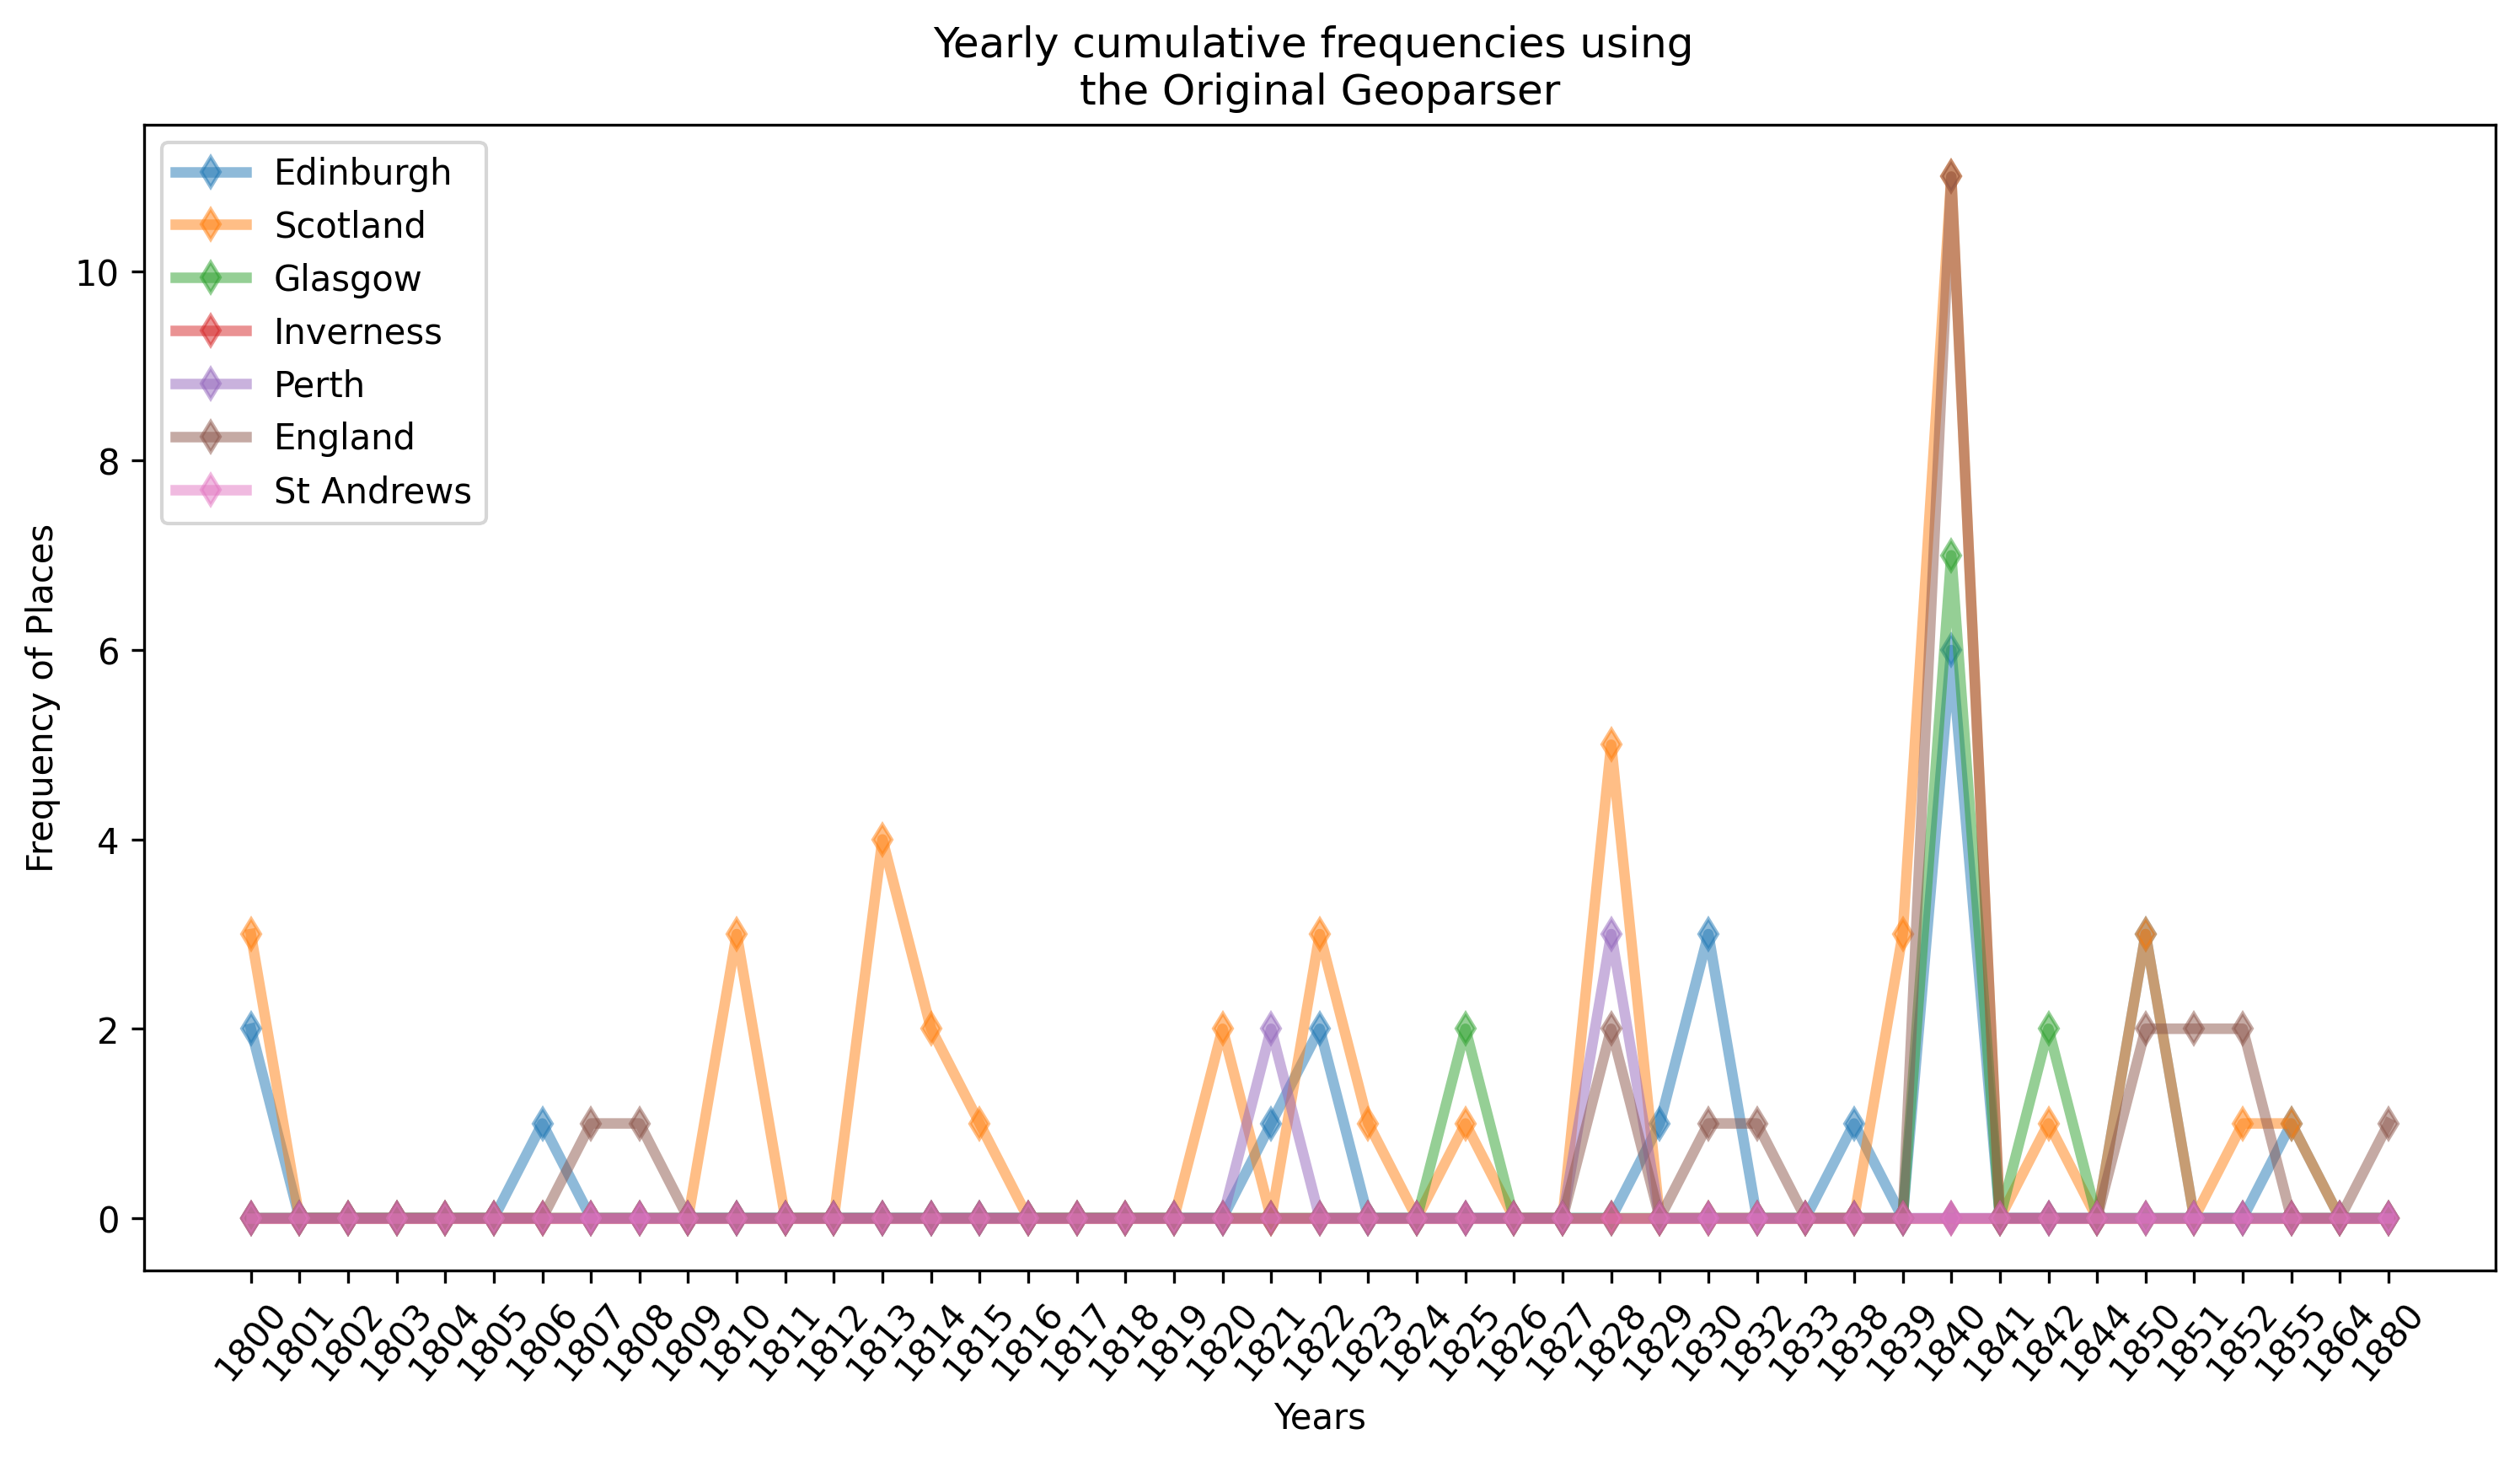

In [41]:
#mpl.rcParams['figure.dpi']=80
list_places=["Edinburgh", "Scotland", "Glasgow", "Inverness", "Perth", "England", "St Andrews"]
cumulative_plot(df_group_places_years_final, list_places, sorted(years_list))

### 3. Exploration - Not georesolved places

**Important: Calculating the number of not georesolved places by year**

In [42]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.groupby("Year").count()

In [59]:
df3 = df_not_resolved.copy()
df3['Place']=df_not_resolved['Place'].apply(str.lower)
df_nr_capitalized= df3.copy()
df_nr_capitalized['Place']=df3['Place'].apply(str.capitalize)
#Displaying the first 15 rows
df_nr_capitalized.head(15)

Latitude Longitude      Place  \
0                     Edinburgh   
0                          Bawn   
1                        Reilly   
2                        Reilly   
3                         Sligo   
0                         Chism   
0                          Inna   
1                          Weil   
2                        Willie   
3                        Willie   
4                        Willie   
5                        Willie   
6                        Willie   
7                        Willie   
8                        Willie   

                                             Snippet Page  Year  \
0    his motlier , and into Edinburgh he goes , to a    6  1800   
0  ftcaling my lair Cobleejt 1 Bawn . Then in the...    5  1800   
1  ! 3 taken was poor Reilly with his fair Coolee...    5  1800   
2  . nd taken was poor Reilly and laid in Sligo gbal    5  1800   
3     poor Reilly and laid in Sligo gbal , . 11 this    5  1800   
0              X , ] THE CATE CHISM . That is to say   13  1800   
0          wife , for ye w Inna ken their Drape wi ’    3  1800   
1            a w ise Willie . Weil , mither , l will    3  1800   
2         e you the better ! Willie . Bat mither , i    3  1800   
3         t ! Muher Indeed , Willie , ye may try gin    3  1800   
4            but tak my advice , Willie an ’ ne ’ er    3  1800   
5  as a browfterwile ’s backlide Willie Well , mi...    3  1800   
6      ? Mither . Indeed , Willie , ye may try Belly    3  1800   
7          to court a w ise Willie . Weil , mither ,    3  1800   
8   , for my bleffi ig Willie , lae the kifies thick    3  1800   

           Archive_id                                              Title  \
0  104184353-mets.xml  history and comical transactions of Lothian To...   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   
2  104184487-mets.xml                      Four excellent new songs,1800   
3  104184487-mets.xml                      Four excellent new songs,1800   
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186547-mets.xml                              art of courtship,1800   
1  104186547-mets.xml                              art of courtship,1800   
2  104186547-mets.xml                              art of courtship,1800   
3  104186547-mets.xml                              art of courtship,1800   
4  104186547-mets.xml                              art of courtship,1800   
5  104186547-mets.xml                              art of courtship,1800   
6  104186547-mets.xml                              art of courtship,1800   
7  104186547-mets.xml                              art of courtship,1800   
8  104186547-mets.xml                              art of courtship,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9937094823804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...  
2  https://w3id.org/nls/i/Page/9937146693804340_1...  
3  https://w3id.org/nls/i/Page/9937146693804340_1...  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740643804340_1...  
1  https://w3id.org/nls/i/Page/9937740643804340_1...  
2  https://w3id.org/nls/i/Page/9937740643804340_1...  
3  https://w3id.org/nls/i/Page/9937740643804340_1...  
4  https://w3id.org/nls/i/Page/9937740643804340_1...  
5  https://w3id.org/nls/i/Page/9937740643804340_1...  
6  https://w3id.org/nls/i/Page/9937740643804340_1...  
7  https://w3id.org/nls/i/Page/9937740643804340_1...  
8  https://w3id.org/nls/i/Page/9937740643804340_1...

In [47]:
df_nr_capitalized.groupby("Year").count()

Latitude  Longitude  Place  Snippet  Page  Archive_id  Title  URI
Year                                                                   
1800       892        892    892      892   892         892    892  892
1801       271        271    271      271   271         271    271  271
1802       163        163    163      163   163         163    163  163
1803        83         83     83       83    83          83     83   83
1804        68         68     68       68    68          68     68   68
...        ...        ...    ...      ...   ...         ...    ...  ...
1870        43         43     43       43    43          43     43   43
1871        20         20     20       20    20          20     20   20
1873         1          1      1        1     1           1      1    1
1879         4          4      4        4     4           4      4    4
1880        60         60     60       60    60          60     60   60

[64 rows x 8 columns]

In [55]:
mpl.rcParams['figure.dpi']=300
years_list_total = df_nr_capitalized['Year'].unique()

## JUST A TRICK TO VISUALIZE THE FIRST 10 YEARS
#years_list=years_list_total[0:10]
years_list=years_list_total[:]
print(years_list)
###

filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_nr_capitalized.loc[df_nr_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'United presbyterian']    
    df_max_filter= df_max_geolocations[~df_max_geolocations['Place'].isin(filter_list)]
    place_label= df_max_filter['Place'].tolist()[0:15]
    place_freq= df_max_filter['count'].tolist()[0:15]
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False).sort_values(['count'], ascending=False)   
        
    df_group_places_years[y]=df_group_places

['1800' '1801' '1802' '1803' '1804' '1805' '1806' '1807' '1808' '1809'
 '1810' '1811' '1812' '1813' '1814' '1815' '1816' '1817' '1818' '1819'
 '1820' '1821' '1822' '1823' '1824' '1825' '1826' '1827' '1828' '1829'
 '1830' '1831' '1832' '1833' '1834' '1835' '1836' '1837' '1838' '1839'
 '1840' '1841' '1842' '1843' '1844' '1845' '1846' '1847' '1850' '1851'
 '1852' '1853' '1855' '1856' '1857' '1858' '1860' '1864' '1866' '1870'
 '1871' '1873' '1879' '1880']


In [56]:
plot_bar_places_by_years(df_group_places_years,plot_type="not resolved")

/var/folders/4w/57rlv27n3g9b001td63pv1j00000gq/T/ipykernel_60376/4115186138.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,0].set_yticklabels(axs[i,0].get_yticklabels())


In [57]:
df_group_places_years_final = pd.concat(df_group_places_years)

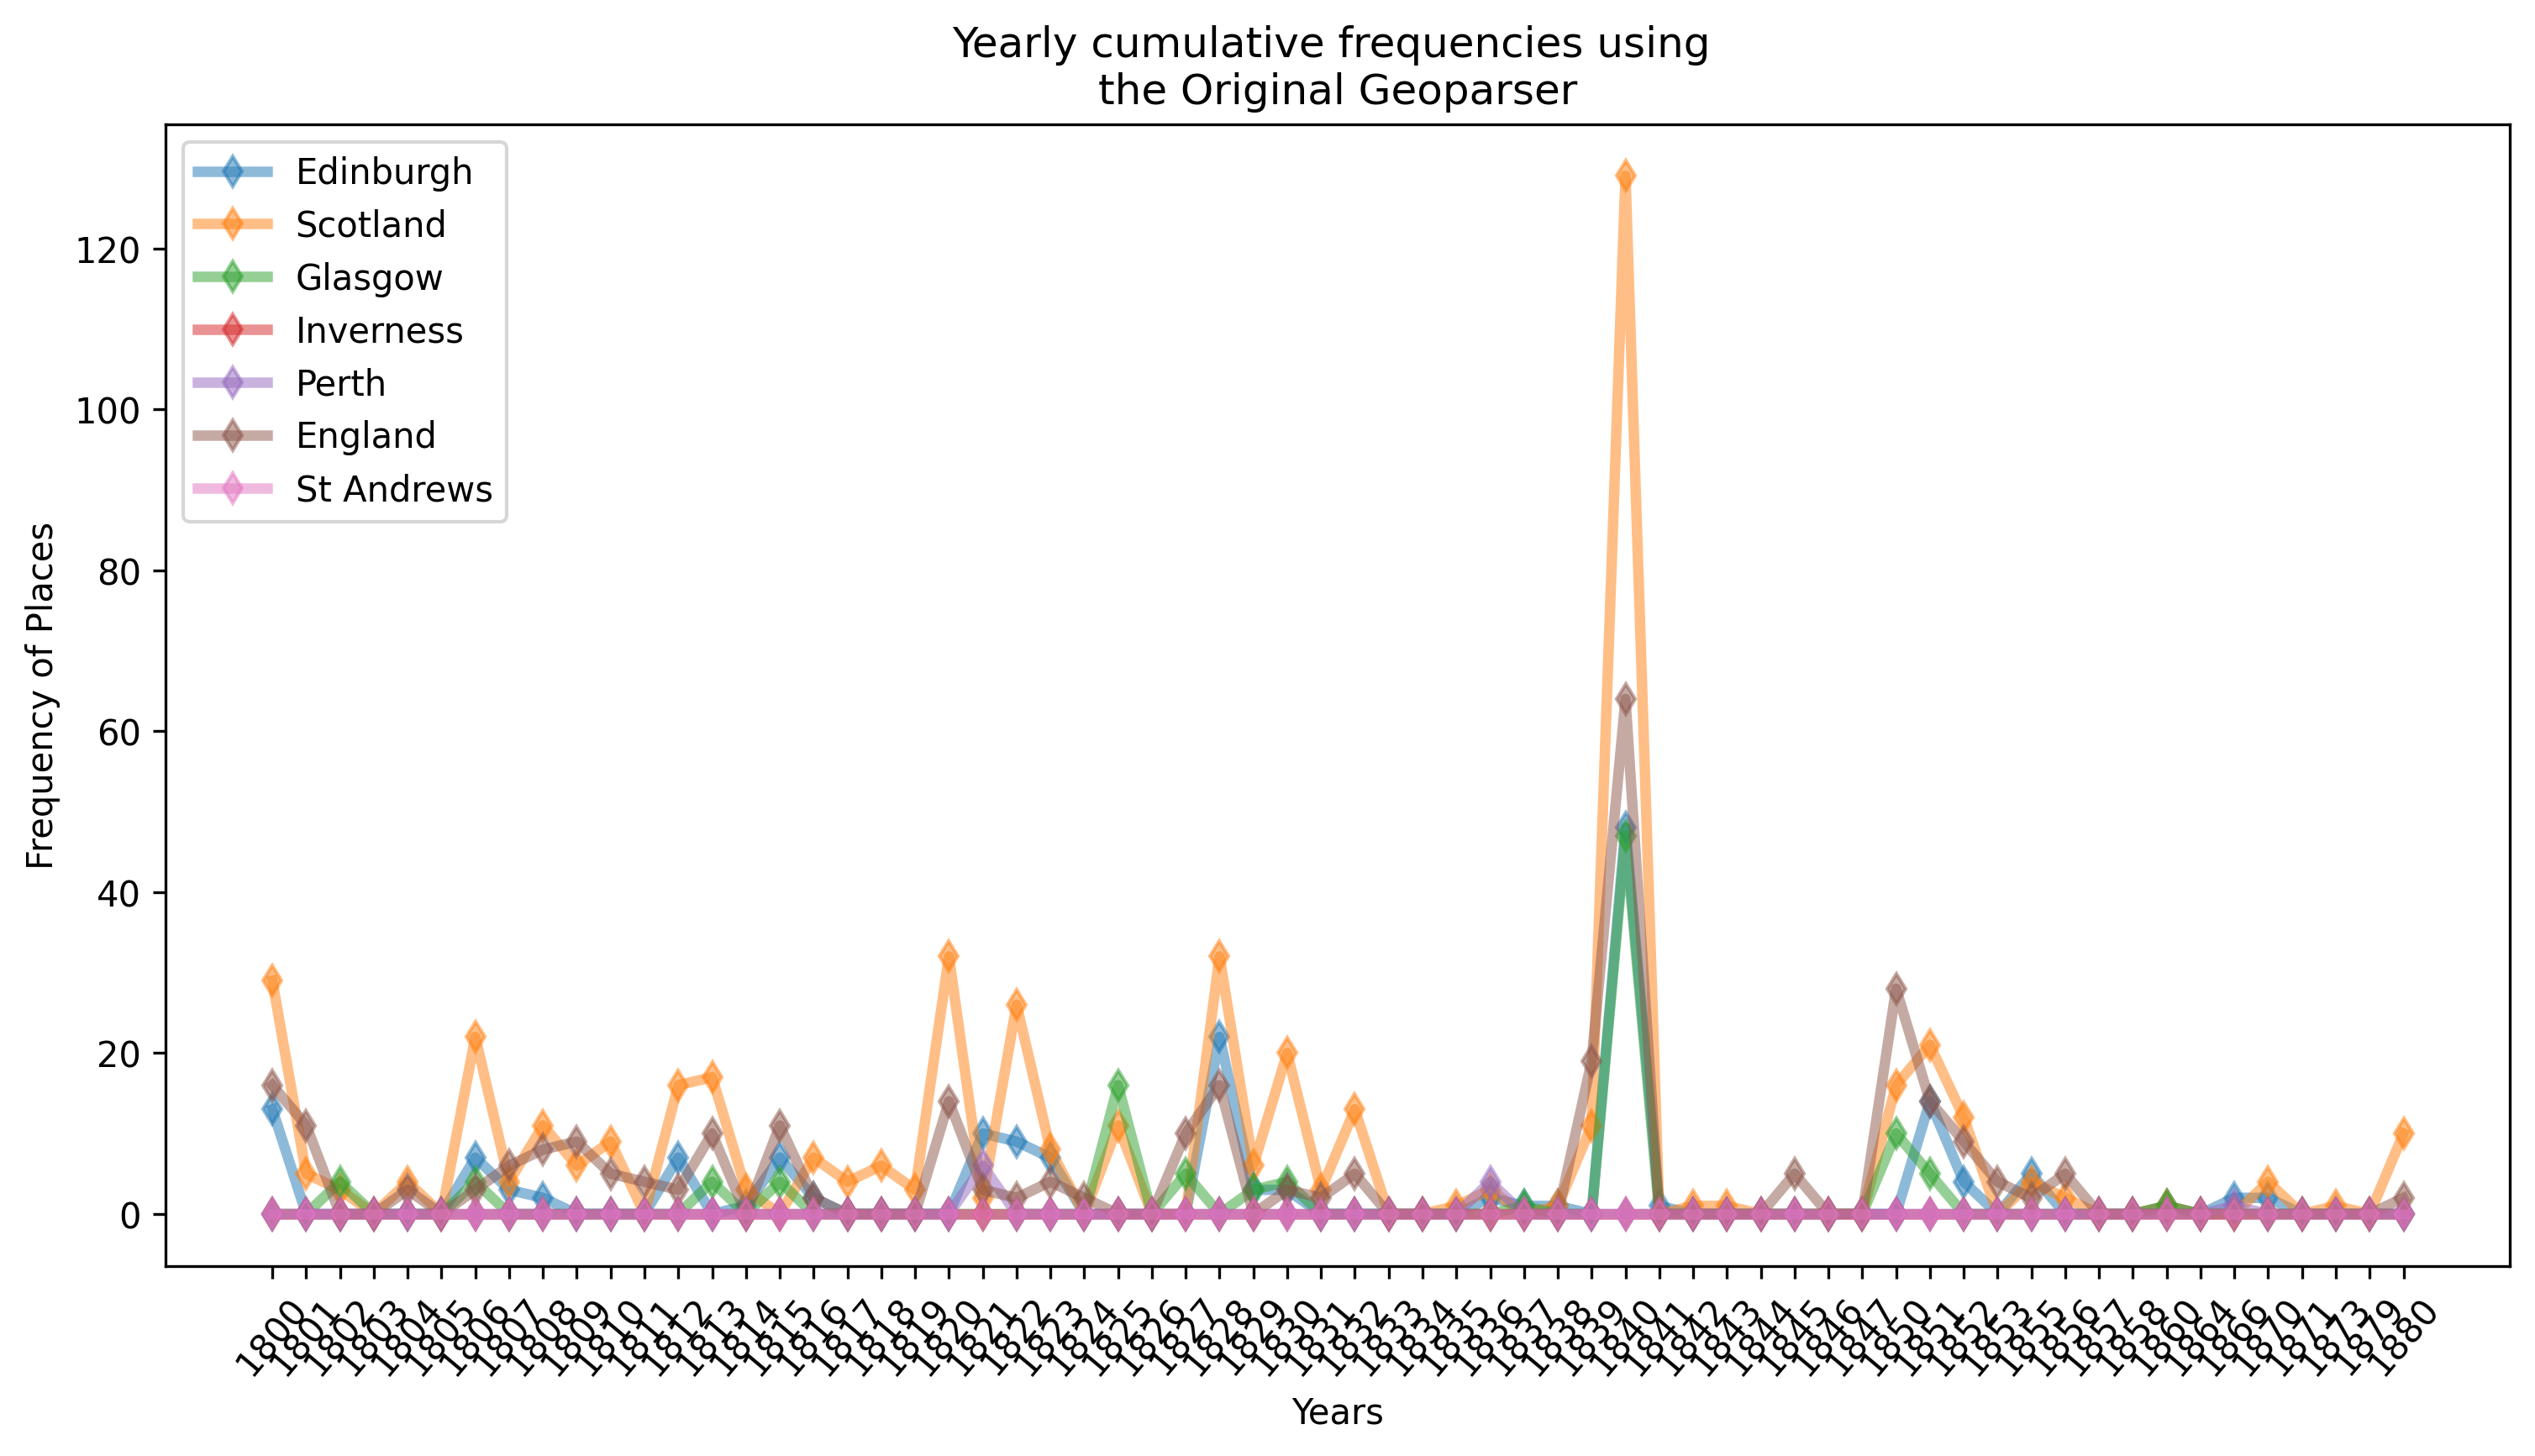

In [58]:
#mpl.rcParams['figure.dpi']=80
list_places=["Edinburgh", "Scotland", "Glasgow", "Inverness", "Perth", "England", "St Andrews"]
cumulative_plot(df_group_places_years_final, list_places, sorted(years_list))

### 4. Exploration total (Resolved and Not Resolved)

In [60]:
df4 = df_total.copy()
df4['Place']=df_total['Place'].apply(str.lower)
dft_capitalized= df4.copy()
dft_capitalized['Place']=df4['Place'].apply(str.capitalize)
#Displaying the first 15 rows
dft_capitalized.head(15)

Latitude Longitude      Place  \
0                     Edinburgh   
0                          Bawn   
1                        Reilly   
2                        Reilly   
3                         Sligo   
0                         Chism   
0                          Inna   
1                          Weil   
2                        Willie   
3                        Willie   
4                        Willie   
5                        Willie   
6                        Willie   
7                        Willie   
8                        Willie   

                                             Snippet Page  Year  \
0    his motlier , and into Edinburgh he goes , to a    6  1800   
0  ftcaling my lair Cobleejt 1 Bawn . Then in the...    5  1800   
1  ! 3 taken was poor Reilly with his fair Coolee...    5  1800   
2  . nd taken was poor Reilly and laid in Sligo gbal    5  1800   
3     poor Reilly and laid in Sligo gbal , . 11 this    5  1800   
0              X , ] THE CATE CHISM . That is to say   13  1800   
0          wife , for ye w Inna ken their Drape wi ’    3  1800   
1            a w ise Willie . Weil , mither , l will    3  1800   
2         e you the better ! Willie . Bat mither , i    3  1800   
3         t ! Muher Indeed , Willie , ye may try gin    3  1800   
4            but tak my advice , Willie an ’ ne ’ er    3  1800   
5  as a browfterwile ’s backlide Willie Well , mi...    3  1800   
6      ? Mither . Indeed , Willie , ye may try Belly    3  1800   
7          to court a w ise Willie . Weil , mither ,    3  1800   
8   , for my bleffi ig Willie , lae the kifies thick    3  1800   

           Archive_id                                              Title  \
0  104184353-mets.xml  history and comical transactions of Lothian To...   
0  104184487-mets.xml                      Four excellent new songs,1800   
1  104184487-mets.xml                      Four excellent new songs,1800   
2  104184487-mets.xml                      Four excellent new songs,1800   
3  104184487-mets.xml                      Four excellent new songs,1800   
0  104187086-mets.xml  earnest persuasive to the serious observance o...   
0  104186547-mets.xml                              art of courtship,1800   
1  104186547-mets.xml                              art of courtship,1800   
2  104186547-mets.xml                              art of courtship,1800   
3  104186547-mets.xml                              art of courtship,1800   
4  104186547-mets.xml                              art of courtship,1800   
5  104186547-mets.xml                              art of courtship,1800   
6  104186547-mets.xml                              art of courtship,1800   
7  104186547-mets.xml                              art of courtship,1800   
8  104186547-mets.xml                              art of courtship,1800   

                                                 URI  
0  https://w3id.org/nls/i/Page/9937094823804340_1...  
0  https://w3id.org/nls/i/Page/9937146693804340_1...  
1  https://w3id.org/nls/i/Page/9937146693804340_1...  
2  https://w3id.org/nls/i/Page/9937146693804340_1...  
3  https://w3id.org/nls/i/Page/9937146693804340_1...  
0  https://w3id.org/nls/i/Page/9930840353804340_1...  
0  https://w3id.org/nls/i/Page/9937740643804340_1...  
1  https://w3id.org/nls/i/Page/9937740643804340_1...  
2  https://w3id.org/nls/i/Page/9937740643804340_1...  
3  https://w3id.org/nls/i/Page/9937740643804340_1...  
4  https://w3id.org/nls/i/Page/9937740643804340_1...  
5  https://w3id.org/nls/i/Page/9937740643804340_1...  
6  https://w3id.org/nls/i/Page/9937740643804340_1...  
7  https://w3id.org/nls/i/Page/9937740643804340_1...  
8  https://w3id.org/nls/i/Page/9937740643804340_1...

In [61]:
dft_capitalized.groupby("Year").count()

Latitude  Longitude  Place  Snippet  Page  Archive_id  Title  URI
Year                                                                   
1800       963        963    963      963   963         963    963  963
1801       302        302    302      302   302         302    302  302
1802       180        180    180      180   180         180    180  180
1803        86         86     86       86    86          86     86   86
1804        72         72     72       72    72          72     72   72
...        ...        ...    ...      ...   ...         ...    ...  ...
1870        43         43     43       43    43          43     43   43
1871        20         20     20       20    20          20     20   20
1873         1          1      1        1     1           1      1    1
1879         4          4      4        4     4           4      4    4
1880        65         65     65       65    65          65     65   65

[64 rows x 8 columns]

In [64]:
mpl.rcParams['figure.dpi']=300
years_list_total = dft_capitalized['Year'].unique()

## JUST A TRICK TO VISUALIZE THE FIRST 10 YEARS
#years_list=years_list_total[0:10]
years_list=years_list_total[:]
print(years_list)
###

filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_nr_capitalized.loc[dft_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'United presbyterian']    
    df_max_filter= df_max_geolocations[~df_max_geolocations['Place'].isin(filter_list)]
    place_label= df_max_filter['Place'].tolist()[0:15]
    place_freq= df_max_filter['count'].tolist()[0:15]
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False).sort_values(['count'], ascending=False)   
        
    df_group_places_years[y]=df_group_places

['1800' '1801' '1802' '1803' '1804' '1805' '1806' '1807' '1808' '1809'
 '1810' '1811' '1812' '1813' '1814' '1815' '1816' '1817' '1818' '1819'
 '1820' '1821' '1822' '1823' '1824' '1825' '1826' '1827' '1828' '1829'
 '1830' '1831' '1832' '1833' '1834' '1835' '1836' '1837' '1838' '1839'
 '1840' '1841' '1842' '1843' '1844' '1845' '1846' '1847' '1850' '1851'
 '1852' '1853' '1855' '1856' '1857' '1858' '1860' '1864' '1866' '1870'
 '1871' '1873' '1879' '1880']


KeyboardInterrupt: 

In [ ]:
plot_bar_places_by_years(df_group_places_years,plot_type="total")

In [ ]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [ ]:
#mpl.rcParams['figure.dpi']=80
list_places=["Edinburgh", "Scotland", "Glasgow", "Inverness", "Perth", "England", "St Andrews"]
cumulative_plot(df_group_places_years_final, list_places, sorted(years_list))